In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import jensenshannon
import pandas as pd
import pyBigWig as pw
import os 

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
data = pd.read_csv("configs/model_dir_subsample_atac.csv", sep=",", header=None, names=["fold", "read_depth", "cell_line", "path"])
data = data[data["fold"]=="fold_0"]

data

,fold,read_depth,cell_line,path
0,fold_0,572M,GM12878,/mnt/lab_data2/anusri/chrombpnet/results/chrom...
5,fold_0,250M,GM12878,/oak/stanford/groups/akundaje/projects/chromat...
10,fold_0,100M,GM12878,/oak/stanford/groups/akundaje/projects/chromat...
15,fold_0,50M,GM12878,/oak/stanford/groups/akundaje/projects/chromat...
20,fold_0,25M,GM12878,/oak/stanford/groups/akundaje/projects/chromat...
25,fold_0,5M,GM12878,/oak/stanford/groups/akundaje/projects/chromat...


In [3]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

peaks_df=pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/filtered.peaks.bed", sep="\t", names=NARROWPEAK_SCHEMA)
peaks_df = peaks_df
peaks_df

,chr,start,end,1,2,3,4,5,6,summit
0,chr10,100006179,100007627,Peak_129135,970,.,2.87048,97.04913,95.00385,535
1,chr10,100006179,100007627,Peak_173791,508,.,2.28123,50.81154,48.91285,791
2,chr10,100006179,100007627,Peak_176997,486,.,2.25177,48.66633,46.77644,1352
3,chr10,100006179,100007627,Peak_275211,160,.,1.65440,16.01422,14.33124,1178
4,chr10,100006179,100007627,Peak_74001,1000,.,4.38566,257.53198,255.19798,285
...,...,...,...,...,...,...,...,...,...,...
275537,chr6,9986231,9986949,Peak_98888,1000,.,7.51163,161.72119,159.53831,426
275538,chr6,99868121,99868883,Peak_179643,470,.,4.38829,47.07563,45.19226,363
275539,chr6,99868121,99868883,Peak_72515,1000,.,11.73258,265.15918,262.81454,125
275540,chr6,9989550,9989841,Peak_219907,284,.,3.22789,28.42596,26.64051,178


## Utils

In [4]:
def get_cts(peaks_df, bw, width):
    """
    Fetches values from a bigwig bw, given a df with minimally
    chr, start and summit columns. Summit is relative to start.
    Retrieves values of specified width centered at summit.
    "cts" = per base counts across a region
    """
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(np.nan_to_num(bw.values(r['chr'], 
                                            r['start'] + r['summit'] - width//2,
                                            r['start'] + r['summit'] + width//2)))
        
    return np.array(vals)

In [5]:
def jsd_pred(profile1_preds, profile2_preds):
    assert(profile1_preds.shape==profile2_preds.shape)
    jsd_vals=[]
    for key in range(profile1_preds.shape[0]):
        jsd_val = jensenshannon(profile1_preds[key], profile2_preds[key])
        if np.isnan(jsd_val):
            #print(np.sum(profile1_preds[key]),np.sum(profile2_preds[key]))
            pass
        else:
            jsd_vals.append(jsd_val)
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals

In [6]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

def read_and_plot(in_title, peaks_df, in_500M, in_250M, in_100M, in_50M, in_25M, in_5M):
    d_in_500M  = get_cts(peaks_df, in_500M, width=1000)
    d_in_250M  = get_cts(peaks_df, in_250M, width=1000)
    d_in_100M  = get_cts(peaks_df, in_100M, width=1000)
    d_in_50M  = get_cts(peaks_df, in_50M, width=1000)
    d_in_25M  = get_cts(peaks_df, in_25M, width=1000)
    d_in_5M  = get_cts(peaks_df, in_5M, width=1000)

    stats_500Mv250M, vals_500Mv250M = jsd_pred(d_in_500M, d_in_250M)
    print("500M vs 250M JSD", stats_500Mv250M)
    stats_500Mv100M, vals_500Mv100M = jsd_pred(d_in_500M, d_in_100M)
    print("500M vs 100M JSD", stats_500Mv100M)
    stats_500Mv50M, vals_500Mv50M = jsd_pred(d_in_500M, d_in_50M)
    print("500M vs 50M JSD", stats_500Mv50M)
    stats_500Mv25M, vals_500Mv25M = jsd_pred(d_in_500M, d_in_25M)
    print("500M vs 25M JSD", stats_500Mv25M)
    stats_500Mv5M, vals_500Mv5M = jsd_pred(d_in_500M, d_in_5M)
    print("500M vs 5M JSD", stats_500Mv5M)
    
    plt.figure(figsize=(15, 10))
    title=in_title
    title1=title
    ecdf = ECDF(vals_500Mv250M)
    plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 250M " +title1)
    ecdf = ECDF(vals_500Mv100M)
    plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 100M " +title1)
    ecdf = ECDF(vals_500Mv50M)
    plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 50M " +title1)
    ecdf = ECDF(vals_500Mv25M)
    plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 25M " +title1)
    ecdf = ECDF(vals_500Mv5M)
    plt.plot(ecdf.x, ecdf.y,label="500M " + title + " vs 5M " +title1)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("JSD values", fontsize=18)
    plt.ylabel("ECDF", fontsize=18)
    plt.savefig("subfigs/profiles_compare/"+title.replace(" ","_")+".pdf", dpi=300, transparent=True)
    plt.show()

## Observed

In [7]:
obs_500M=pw.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw")
obs_250M=pw.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data_250M/GM12878_unstranded.bw")
obs_100M=pw.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data_100M/GM12878_unstranded.bw")
obs_50M=pw.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data_50M/GM12878_unstranded.bw")
obs_25M=pw.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data_25M/GM12878_unstranded.bw")
obs_5M=pw.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data_5M/GM12878_unstranded.bw")

500M vs 250M JSD [0.2589529974434685, 0.07853545273506796]
500M vs 100M JSD [0.40966278447813087, 0.10414106660103851]
500M vs 50M JSD [0.5075367105991487, 0.10842790112006533]


/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=axis, keepdims=True)


500M vs 25M JSD [0.5924634397538715, 0.10241246804270608]
500M vs 5M JSD [0.7285807971763167, 0.0646277938064738]


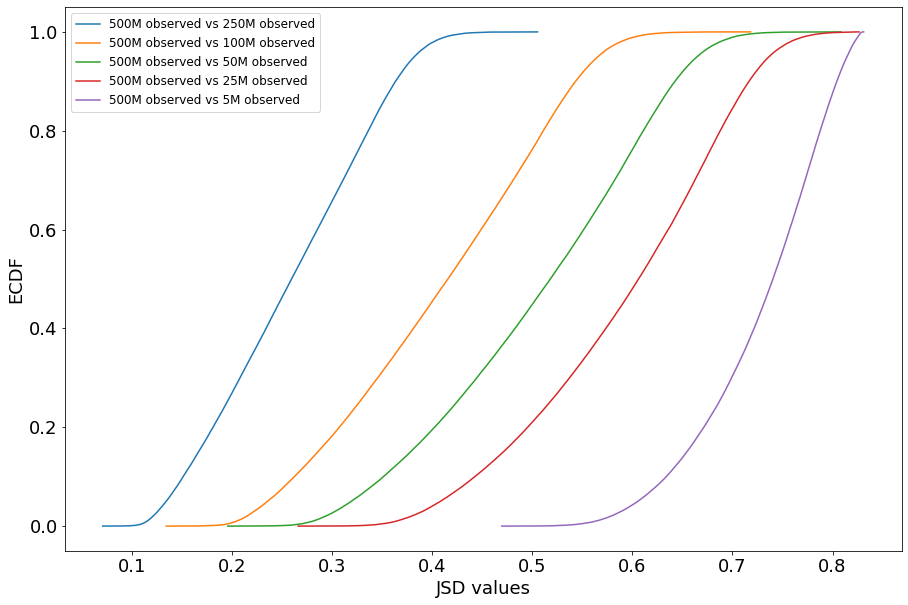

In [8]:
read_and_plot("observed", peaks_df, obs_500M, obs_250M, obs_100M, obs_50M, obs_25M, obs_5M)

## Uncorrected predicted profiles

In [13]:
read_depth_query="572M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"interpret/GM12878_w_bias.bw")
#path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_w_bias.bw")
in_500M = pw.open(path)

read_depth_query="250M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_w_bias.bw")
in_250M = pw.open(path)

read_depth_query="100M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_w_bias.bw")

in_100M = pw.open(path)

read_depth_query="50M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_w_bias.bw")

in_50M = pw.open(path)

read_depth_query="25M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_w_bias.bw")


in_25M = pw.open(path)

read_depth_query="5M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_w_bias.bw")
in_5M = pw.open(path)

500M vs 250M JSD [0.127193376559424, 0.02624872734407189]
500M vs 100M JSD [0.12520111667370826, 0.02416865124287686]
500M vs 50M JSD [0.13206613565102052, 0.025917792838353416]
500M vs 25M JSD [0.13483061970829036, 0.027378488703174993]
500M vs 5M JSD [0.16566147150244234, 0.04060470583553641]


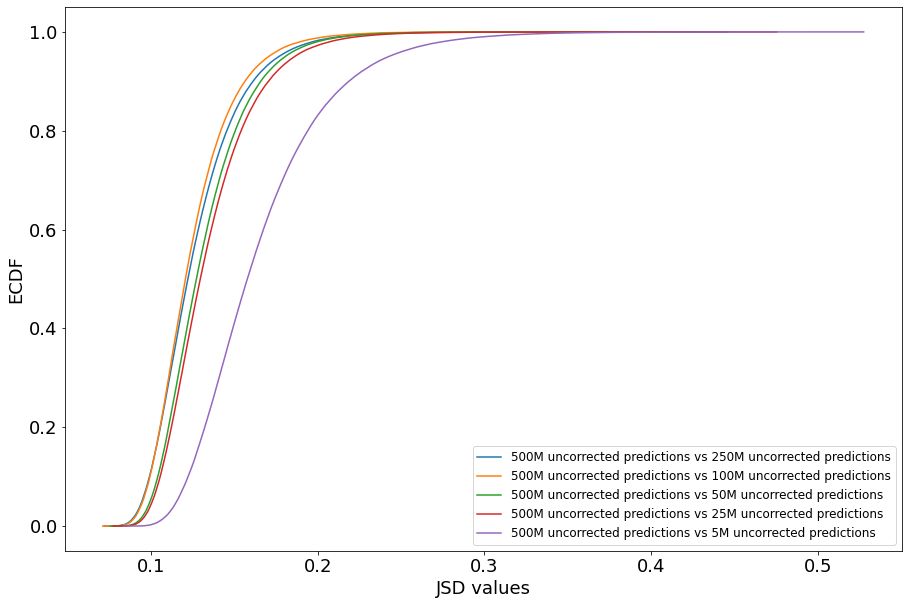

In [14]:
read_and_plot("uncorrected predictions", peaks_df, in_500M, in_250M, in_100M, in_50M, in_25M, in_5M)

## Corrected predicted profiles

In [15]:
read_depth_query="572M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"interpret/GM12878_wo_bias.bw")
#path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_wo_bias.bw")
in_500M = pw.open(path)

read_depth_query="250M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_wo_bias.bw")
in_250M = pw.open(path)

read_depth_query="100M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_wo_bias.bw")

in_100M = pw.open(path)

read_depth_query="50M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_wo_bias.bw")

in_50M = pw.open(path)

read_depth_query="25M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_wo_bias.bw")


in_25M = pw.open(path)

read_depth_query="5M"
path = os.path.join(data[data["read_depth"] == read_depth_query]["path"].values[0],"chrombpnet_model/interpret/full_GM12878_"+read_depth_query+"_wo_bias.bw")
in_5M = pw.open(path)

500M vs 250M JSD [0.12876414850192955, 0.028816838355343564]
500M vs 100M JSD [0.1245621926076437, 0.026990024598367777]
500M vs 50M JSD [0.13160162024945804, 0.027851422014559656]
500M vs 25M JSD [0.13300366714705733, 0.030026652506465176]
500M vs 5M JSD [0.16502850896520574, 0.043078189871676505]


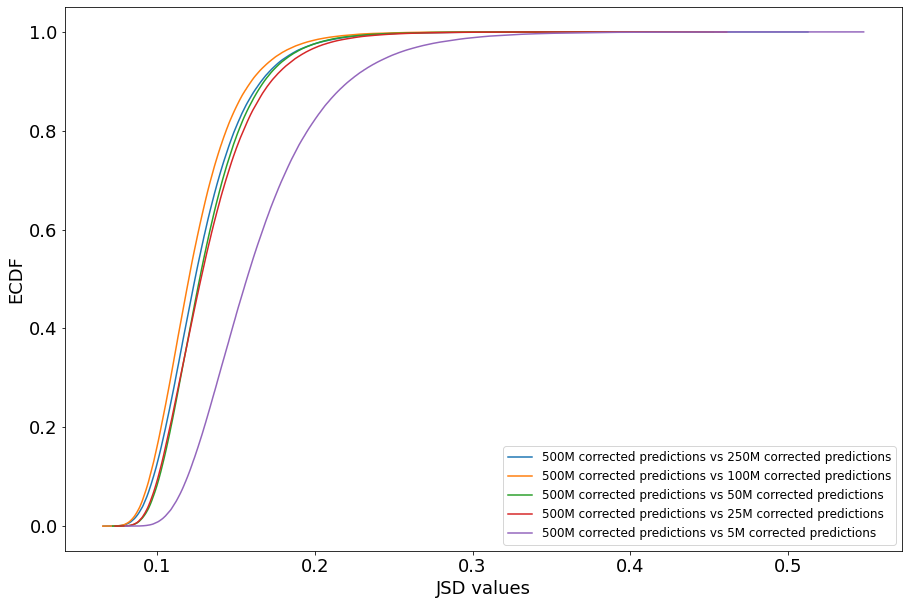

In [16]:
read_and_plot("corrected predictions", peaks_df, in_500M, in_250M, in_100M, in_50M, in_25M, in_5M)